In [17]:
%pip install qiskit

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error

import numpy as np
import random

from multiprocessing import Pool
import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### this function builds a Quantum Fourier Transform* gate

*it's a modified version without swaps

In [2]:
def QuantumFourierTransform(digits: int):
    
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegY)

    for i, q in enumerate(QRegY):
        QC.h(q)

        theta = np.pi / 2
        for r in QRegY[i + 1:]:
            QC.cp(theta, r, q)
            theta /= 2
    
    return QC.to_gate()

#### the following function builds a oracle, $U_C$, such that $U_C | x \rangle | y \rangle = | x \rangle | y - C (x) \rangle$

todo: we can probably save some circuit by removing the swap-gates in QFT and reshuffling gates here

In [3]:
def EnergyOracle(GraphLaplacian: list[list[int]], digits: int):

    QRegX = QuantumRegister(len(GraphLaplacian))
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegX, QRegY)

    QFT = QuantumFourierTransform(digits)
    QC.append(QFT, QRegY)
    
    # Phasers
    for i, v in enumerate(GraphLaplacian):
        theta = - np.pi * v[i]
        # QRegY is reversed below to save on swaps in QFT
        for q in reversed(QRegY):
            QC.cp(theta, QRegX[i], q)
            theta /= 2

        for j, w in enumerate(GraphLaplacian[i][i + 1:]):
            if w != 0:
                theta = - 2 * np.pi * w
                # QRegY is reversed below to save on swaps in QFT
                for q in reversed(QRegY):
                    QC.mcp(theta, [QRegX[i], QRegX[i + 1 + j]], q)
                    theta /= 2

    QC.append(QFT.inverse(), QRegY)

    return QC.to_gate()

#### the following creates the Grover fixed point circuit, $S_L = G \left( \alpha_l, \beta_l \right) \cdots G \left( \alpha_1, \beta_1 \right) H^{\otimes n}$

In [4]:
def GroverFixedPointGate(GraphLaplacian: list[list[int]], digits: int, l: int, delta: float):

    L = 2*l + 1
    gamma = np.sqrt(1 - 1 / pow(np.cosh(np.arccosh(1/delta) / L), 2))

    alpha = [2 * np.arctan(1 / (gamma * np.tan(2 * np.pi * j / L))) for j in range(1, l + 1)]
    
    U_C = EnergyOracle(GraphLaplacian, digits)
    U_C_inverse = U_C.inverse()

    QRegX = QuantumRegister(len(GraphLaplacian), "x")
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegX)

    for i, (a, b) in enumerate(zip(alpha, reversed(alpha))):

        # S_t (beta)
        QC.append(U_C, QRegX[:] + QRegY[:])
        QC.p(- b, QRegY[0])
        if i != l - 1:
            QC.append(U_C_inverse, QRegX[:] + QRegY[:])
        
        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        QC.mcp(a, QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.h(QRegX)

    return QC.to_gate()

### adding a noise model based on IonQ's Aria specifications:

In [7]:
# error probabilities
p_meas = 0.39/100
p_reset = 0.39/100
p_gate1 = 0.06/100
p_gate2 = 0.6/100

# thermal relaxation error (nanosecond time)
T1s = random.sample(range(10, 100, 1), 10) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = random.sample(range(600, 700, 1), 10)
time_u1 = 0 # virtual gate?
time_gate1 = 135e3 # u1 and u2
time_gate2 = 600e3 # 2 qubit gate

### depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for t

In [8]:
# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

### creating the noise model:

In [9]:
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

backend = AerSimulator(noise_model = fake_aria)

#### the following builds the circuit for QAOA

In [10]:
def GroverPlusQAOA(GraphLaplacian: list[list[int]], digits: int, y: int, delta: float, l: int, angles: list[list[int]], NumberOfShots: int):

    # one quantum/classical register pair for each vertex
    QRegX = QuantumRegister(len(GraphLaplacian), "x")
    ClRegX = ClassicalRegister(len(GraphLaplacian), "cl-x")

    # quantum registers to digitize y
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY, ClRegX)

    for q in QRegX:
        QC.initialize([1, 0], q)

    for i, q in enumerate(QRegY):
        # y - 1 is used, so states with f(x) >= y are flagged
        QC.initialize([1 - ((y-1) >> (digits - i - 1))%2, ((y-1) >> (digits - i - 1))%2], q)

    #Grover = GroverFixedPointGate(GraphLaplacian, digits, l, delta)
    #Grover.label = "Grover"

    QC.append(Grover, QRegX[:] + QRegY[:])

    QC.h(QRegX)
    
    for beta, gamma in angles:
        # Cost bang
        for i, q in enumerate(QRegX):
            if GraphLaplacian[i][i] != 0:
                QC.p(GraphLaplacian[i][i] * 2 * gamma, q)
            for j, r in enumerate(QRegX[:i]):
                if GraphLaplacian[i][j] != 0:
                    QC.cp(GraphLaplacian[i][j] * 4 * gamma, q, r)

        # Mixer bang
        QC.rx(beta, QRegX)

    QC.measure(QRegX, ClRegX)
    
    #display(QC.draw(output='mpl'))

    # simulation
    noisy_simulator = AerSimulator(noise_model=fake_aria)
    transpiled_QC = transpile(QC, noisy_simulator)    
    counts = noisy_simulator.run(transpiled_QC, shots=NumberOfShots).result().get_counts(transpiled_QC)

    M = 0
    bestcut = 0
    bestcutconf = np.zeros(len(GraphLaplacian), dtype=int)
    for s in counts:
        conf = np.array([int(x) for x in reversed(s)])
        m = np.matmul(conf, np.matmul(GraphLaplacian, np.transpose(conf)))
        M += m * counts[s]
        if m > bestcut:
            bestcut = m
            bestcutconf = conf

    return [bestcut, M / NumberOfShots, angles, bestcutconf]

#### graph plotter

In [11]:
import networkx as nx

def createGraph(GraphLaplacian: list[list[int]]):
    Edges = []
    for i, row in enumerate(GraphLaplacian):
        for j, v in enumerate(row[:i]):
            if v == - 1:
                Edges.append([j, i])
    Graph = nx.Graph()
    Graph.add_edges_from(Edges)
    nx.draw_networkx(Graph)

## TESTING:

### parameters

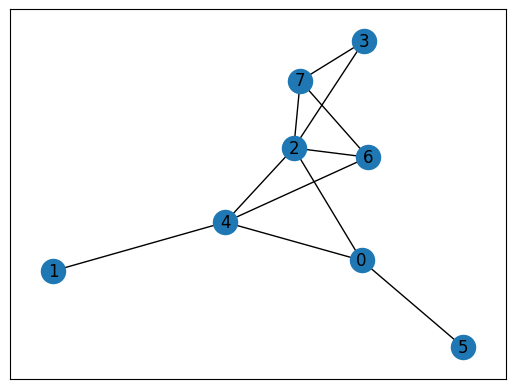

In [21]:
# independent inputs
NumberOfVerticies = 8
RootLambda = 1/3 # ratio of good states to all states
P_L = 0.9
NumberOfShots = 10

# this generates a grid
p = 3
BetaGridSize = 3
jump = 1

BetaPaths = [[beta] for beta in range(1, BetaGridSize)]

for i in range(1, p):
    NewBetaPaths = []
    for betas in BetaPaths:
        for beta in range(1, BetaGridSize):
            if abs(betas[-1] - beta) <= jump:
                NewBetaPaths.append(betas + [beta])
    BetaPaths = NewBetaPaths 

GridPaths = [[[beta, - gamma] for beta, gamma in zip(betas, reversed(betas))] for betas in BetaPaths]

# from the input we compute the following
delta = np.sqrt(1 - P_L)
l = int(np.ceil(np.arccosh(1/delta) / np.arccosh(1/np.sqrt(1 - RootLambda*RootLambda)))) // 2

# create random, connected graph
NumberOfComponents = 0

while NumberOfComponents != 1:
    GraphLaplacian = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
    for i in range(NumberOfVerticies):
        for j in range(i + 1, NumberOfVerticies):
            if np.random.randint(0, 2) == 1:
                GraphLaplacian[i][j] = GraphLaplacian[j][i] = - 1
        GraphLaplacian[i][i] = - np.sum(GraphLaplacian[i])

    NumberOfComponents = NumberOfVerticies - np.linalg.matrix_rank(GraphLaplacian)

createGraph(GraphLaplacian)

NumberOfEdges = np.trace(GraphLaplacian) // 2

y = (4 * NumberOfVerticies + int(np.sqrt(8 * NumberOfVerticies + 1) - 1)) // 8 #if NumberOfComponents == 1 else (2 * NumberOfVerticies + NumberOfEdges - 1) // 4 # one less then the Erdos-Edwards bound
digits = int(np.ceil(np.log2(NumberOfEdges))) + 1 # + 1 for the sign


MaxCut = 0
maxconf = np.zeros((NumberOfVerticies,), dtype=int)

for x in range(1 << (NumberOfVerticies - 1)):
    conf = np.array([(x >> i)&1 for i in range(NumberOfVerticies)])
    cut = np.matmul(conf, np.matmul(GraphLaplacian, np.transpose(conf)))
    if cut > MaxCut:
        MaxCut = cut
        maxconf = conf
if np.sum(maxconf) > (NumberOfVerticies >> 1):
    maxconf = np.ones((NumberOfVerticies,), dtype=int) - maxconf

### results:

In [22]:
def GPQParallel(angles):
    return GroverPlusQAOA(GraphLaplacian, digits, y, delta, l, angles, NumberOfShots)

Grover = GroverFixedPointGate(GraphLaplacian, digits, l, delta)
Grover.label = "Grover"

with Pool() as pool:
    results = list(tqdm.tqdm(pool.imap_unordered(GPQParallel, GridPaths), total=len(GridPaths)))

results.sort(key = lambda x: x[1])

100%|██████████| 8/8 [00:40<00:00,  5.03s/it]


In [24]:
s = f"MaxCut\t\t\t= {MaxCut}\nmaxconf\t\t\t= {maxconf}\n\ncut threshold\t\t= {y}\nGrover query complexity\t= {l}\nsquare root of lambda\t= {round(RootLambda,3)}\nP_L\t\t\t= {P_L * 100}%\np\t\t\t= {p}\nBetaGridSize\t\t= {BetaGridSize}\n\nmaxcut\tM\tconfiguration\t\t\tangle\n\n"
for result in results[-10:]:
    s += f"{result[0]}\t{result[1]}\t{result[3]}\t{result[2]}\n"
s += f"\nthe graph (number of edges = {np.trace(GraphLaplacian) // 2}, maxcut = {MaxCut}, ratio = {results[-1][0] / MaxCut})\n\n"
for row in GraphLaplacian:
    s += f"{row.view()}\n"

print(s)

MaxCut			= 9
maxconf			= [1 1 0 1 0 0 1 0]

cut threshold		= 4
Grover query complexity	= 3
square root of lambda	= 0.333
P_L			= 90.0%
p			= 3
BetaGridSize		= 3

maxcut	M	configuration			angle

7	3.9	[0 1 0 0 1 1 0 1]	[[1, -2], [1, -1], [2, -1]]
7	4.9	[0 0 1 0 1 0 0 0]	[[2, -2], [1, -1], [2, -2]]
7	5.1	[0 1 1 0 0 0 1 0]	[[2, -2], [2, -2], [2, -2]]
8	5.2	[1 1 1 1 0 0 1 0]	[[1, -1], [2, -2], [1, -1]]
8	5.6	[0 0 0 1 1 1 0 1]	[[1, -1], [1, -1], [1, -1]]
7	5.6	[0 1 1 0 1 1 0 0]	[[1, -2], [2, -2], [2, -1]]
8	5.8	[1 1 1 1 0 0 1 0]	[[2, -1], [1, -1], [1, -2]]
8	5.9	[1 1 0 1 0 1 1 0]	[[2, -1], [2, -2], [1, -2]]

the graph (number of edges = 11, maxcut = 9, ratio = 0.8888888888888888)

[ 3  0 -1  0 -1 -1  0  0]
[ 0  1  0  0 -1  0  0  0]
[-1  0  5 -1 -1  0 -1 -1]
[ 0  0 -1  2  0  0  0 -1]
[-1 -1 -1  0  4  0 -1  0]
[-1  0  0  0  0  1  0  0]
[ 0  0 -1  0 -1  0  3 -1]
[ 0  0 -1 -1  0  0 -1  3]

